In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File paths
fr = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"
de = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/DT_Cleaned.csv"
es = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/ES_Cleaned.csv"
it = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/IT_Cleaned.csv"
pt = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/PT_Cleaned.csv"

# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

In [3]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [4]:
# Function to load data in chunks
def load_data_in_chunks(files, dtype_spec, chunksize=10000):
    df_list = []
    for file in files:
        for chunk in pd.read_csv(file, dtype=dtype_spec, chunksize=chunksize):
            df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features

In [5]:
# Ridge Regression function with RandomizedSearchCV and polynomial features
def ridge_regression_with_random_search(df, energy_types, features_dict, alphas, degree=1):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Polynomial Features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_poly)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Parameter grid for alpha
    param_grid = {'alpha': alphas}
    
    # Ridge Regression with RandomizedSearchCV
    ridge = Ridge()
    random_search = RandomizedSearchCV(ridge, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Best model
    best_ridge = random_search.best_estimator_
    best_alpha = random_search.best_params_['alpha']
    
    # Predictions with best model
    y_pred_best = best_ridge.predict(X_test)
    
    # Evaluation of best model
    best_r2 = r2_score(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best R^2 Score: {best_r2}")
    print(f"Mean Squared Error: {mse_best}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted for best model
    sns.scatterplot(x=y_test, y=y_pred_best, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # R^2 scores vs alpha plot
    results_df = pd.DataFrame(random_search.cv_results_)
    sns.lineplot(x='param_alpha', y='mean_test_score', data=results_df, ax=axes[1])
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Mean CV R^2 Score')
    axes[1].set_title('Mean CV R^2 Score vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for best model
    original_features = poly.get_feature_names_out(feature_names)
    coef_df = pd.DataFrame({'Feature': original_features, 'Coefficient': np.abs(best_ridge.coef_)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("Feature Importances:")
    for feature, coef in zip(coef_df['Feature'], coef_df['Coefficient']):
        print(f"{feature}: {coef}")
    
    # Visualization of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_ridge, best_r2, mse_best

In [6]:
# Load data in chunks
files = [fr, de, es]  # Add it and pt if needed
df_clean = load_data_in_chunks(files, dtype_spec)

# Drop specified columns
drop = ["Unnamed: 0", "Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)
#df_clean.drop_duplicates(inplace=True)

Energy Type: petrol
Best Alpha: 2.8330961018393297
Best R^2 Score: 0.7622639814077984
Mean Squared Error: 141.18009064779628


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


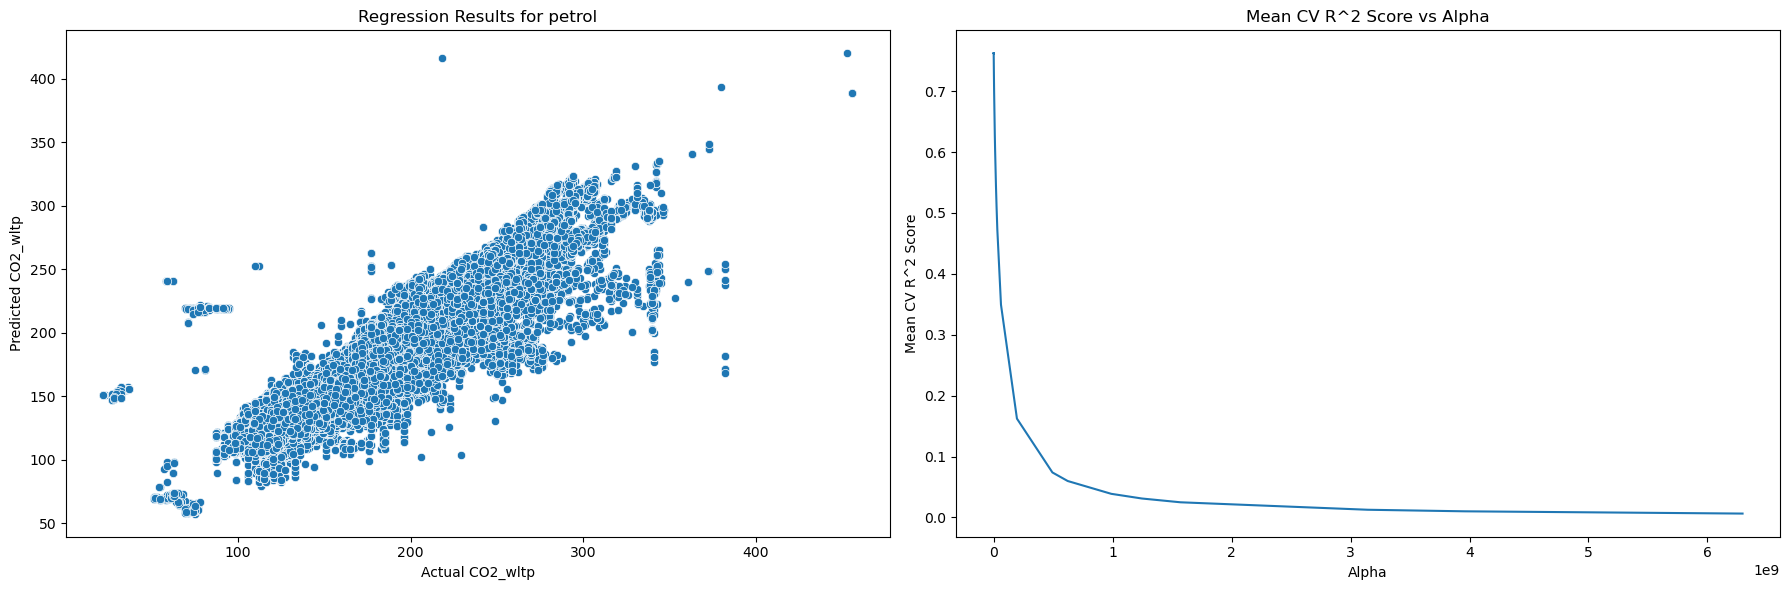

Feature Importances:
Power_KW: 13.030984257440716
Test_mass: 9.718648628100933
Fuel consumption: 9.078147464723916
year: 5.971389722234836
Engine_cm3: 4.822724448574847
Kg_veh: 1.9432109532605293
Erwltp (g/km): 1.9074748037830949
Axle_width_steer_mm: 1.4084495629614753
Wheelbase_mm: 1.377318202632013
El_Consumpt_whkm: 1.2704111063491623
Eco-innovation program: 0.5797047656524864
Axle_width_other_mm: 0.07235878982251585


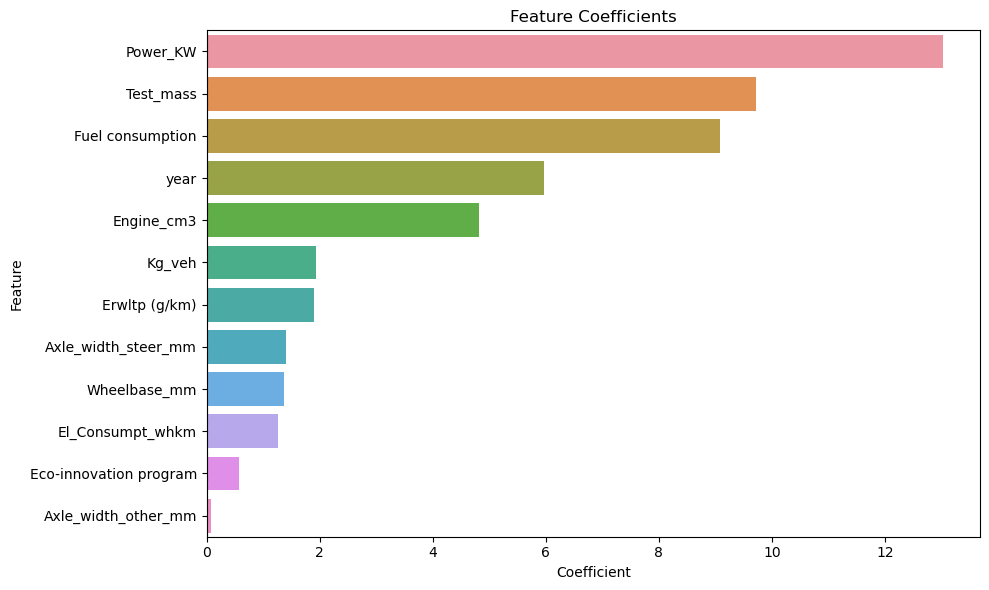

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Energy Type: diesel
Best Alpha: 2.8330961018393297
Best R^2 Score: 0.8652451355283118
Mean Squared Error: 88.41240891745944


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


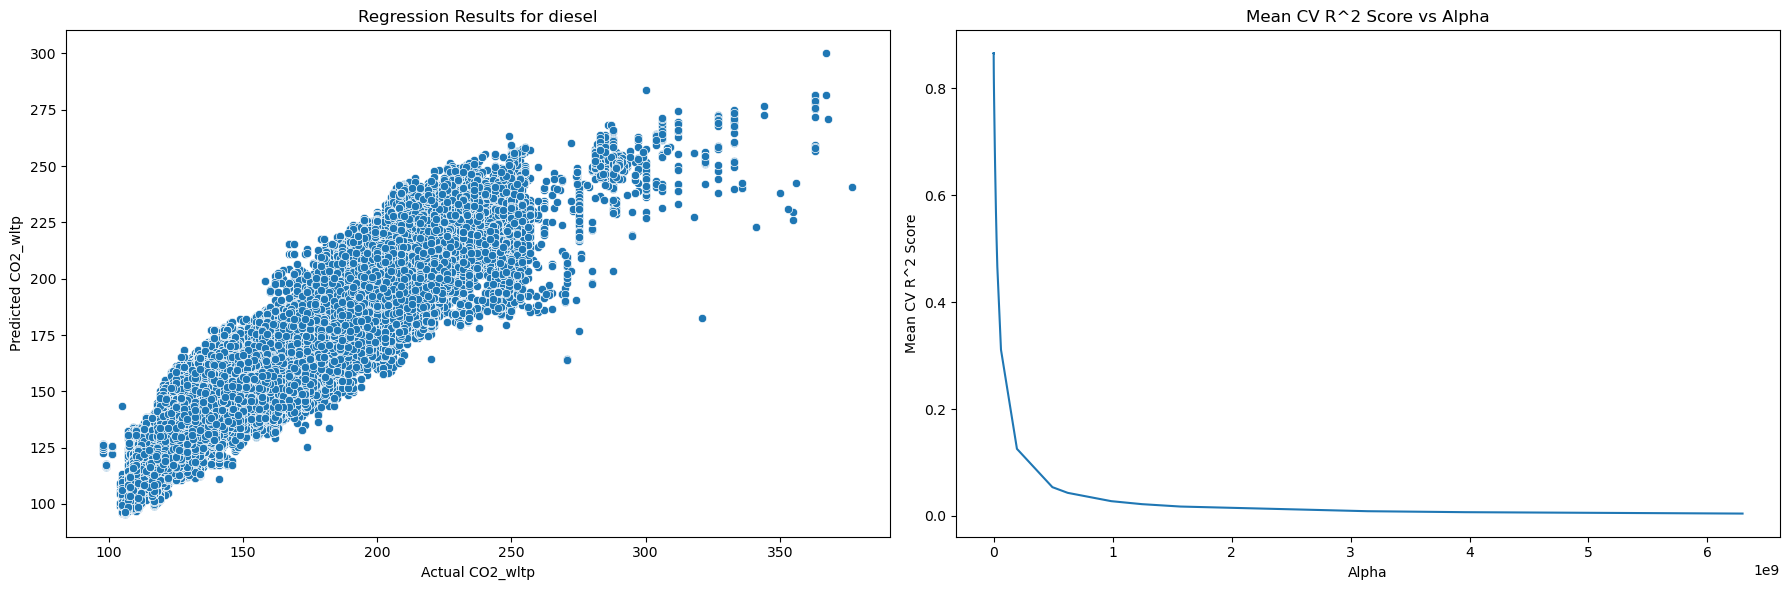

Feature Importances:
Test_mass: 21.070656458649463
Kg_veh: 6.509648620475078
year: 4.748209082036862
Wheelbase_mm: 3.9367584862658975
Fuel consumption: 3.837413113633563
Axle_width_steer_mm: 2.2578355231365794
Axle_width_other_mm: 1.552431604459608
Eco-innovation program: 1.1374723768268074
Power_KW: 0.6994069644625329
Erwltp (g/km): 0.17390324358839485
El_Consumpt_whkm: 0.04517096396527934
Engine_cm3: 0.027386695082982172


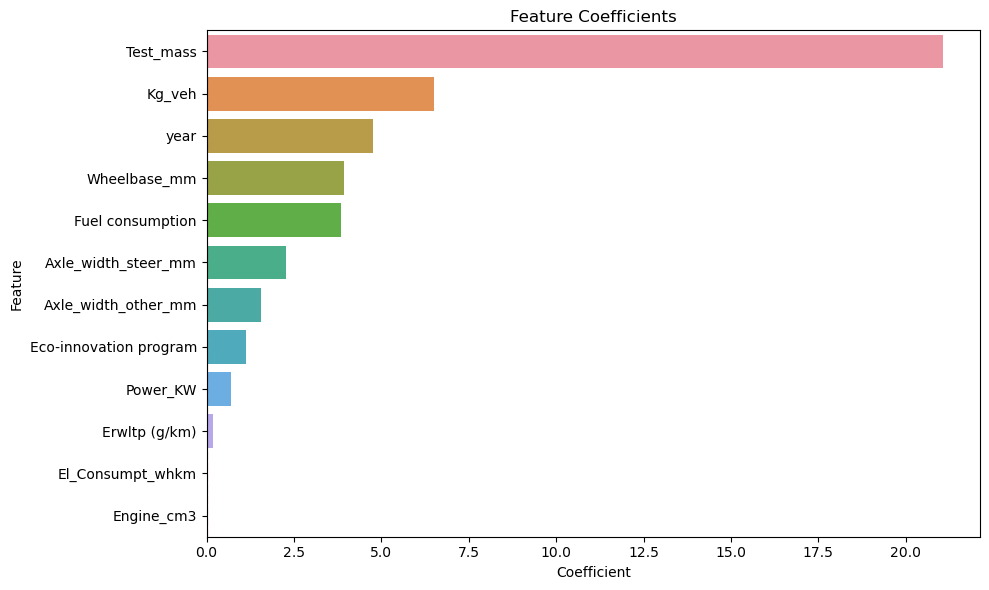

Energy Type: lpg
Best Alpha: 1.4149912974345789
Best R^2 Score: 0.8854560439373786
Mean Squared Error: 19.88136075031277


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


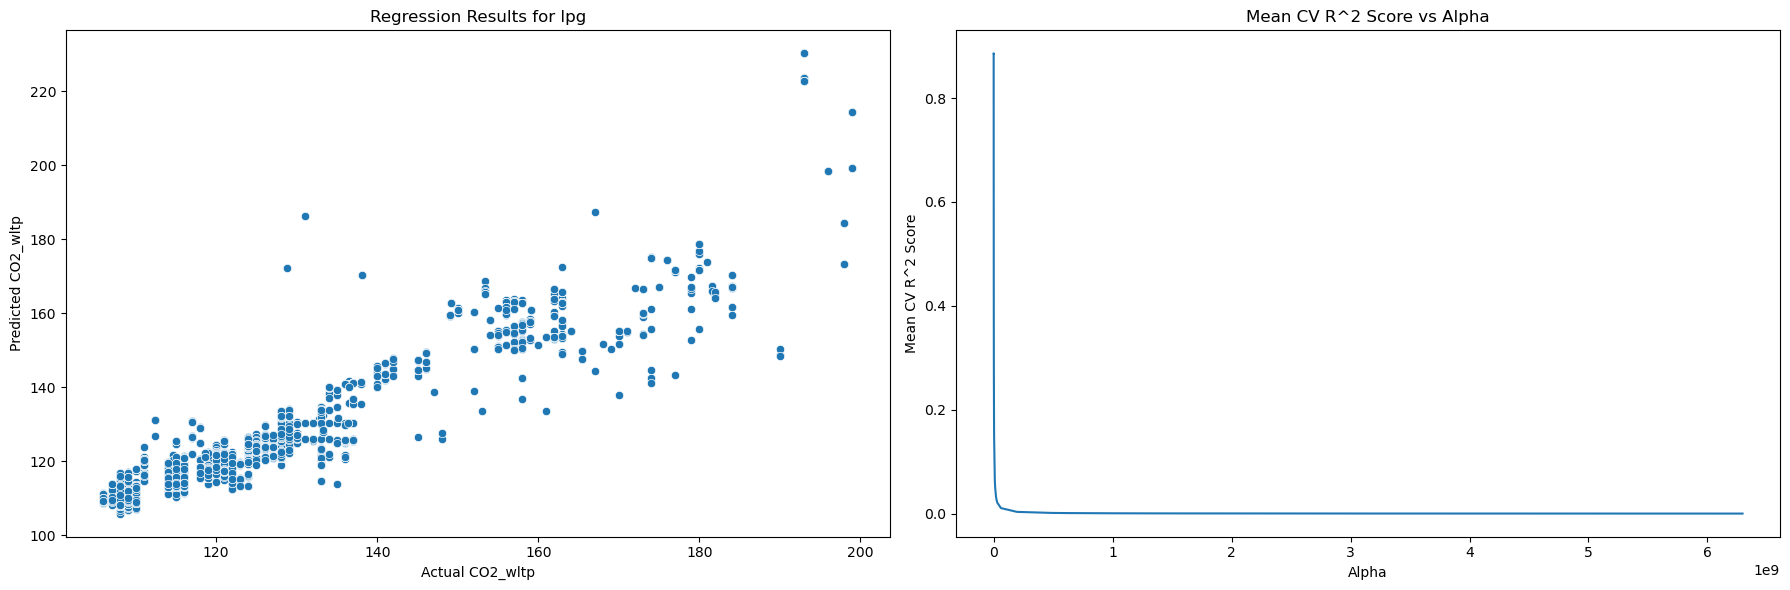

Feature Importances:
Axle_width_other_mm: 10.269375256756833
Axle_width_steer_mm: 9.833890816964145
Test_mass: 8.496413322885239
Engine_cm3: 5.2394873194480995
year: 5.070777871210068
Kg_veh: 3.2916231528644513
Eco-innovation program: 2.9027580662434405
Erwltp (g/km): 2.144536689216667
Power_KW: 1.4354611937582291
Wheelbase_mm: 1.4088486925540586
Fuel consumption: 1.3728182279635097
Electric range (km): 0.0


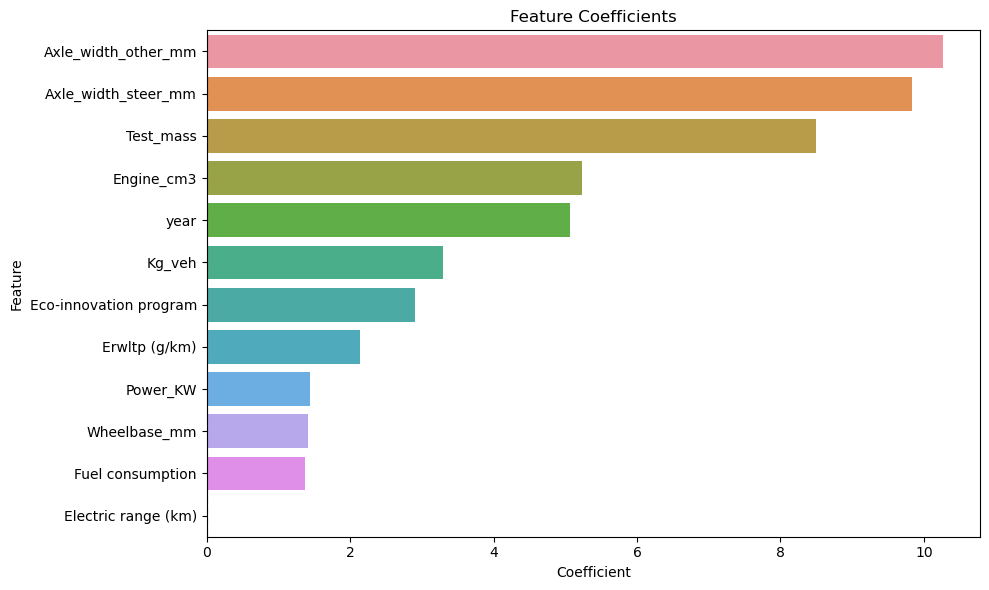

Energy Type: hybrid petrol
Best Alpha: 22.73965752357932
Best R^2 Score: 0.3813972759904467
Mean Squared Error: 146.55054678836356


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


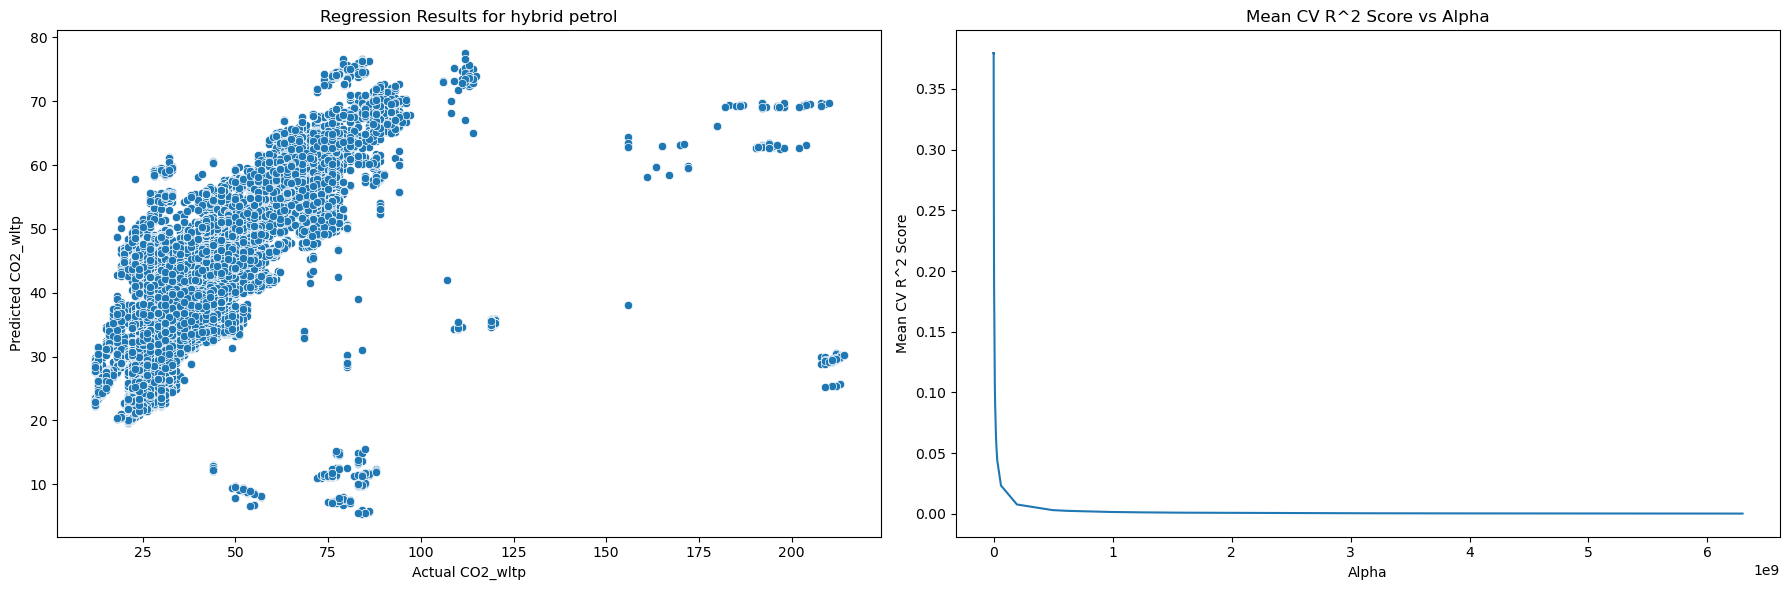

Feature Importances:
Kg_veh: 5.2503509874382726
Electric range (km): 4.553319561219413
year: 3.4569756432088314
Test_mass: 3.0005940494387695
Fuel consumption: 2.543567885345164
Engine_cm3: 1.628596587247295
Power_KW: 1.0707166779209338
Wheelbase_mm: 0.8872226352964913
Axle_width_steer_mm: 0.8749310865212262
Axle_width_other_mm: 0.2983993379092761
El_Consumpt_whkm: 0.2620807434851512
Eco-innovation program: 0.03130850357077348


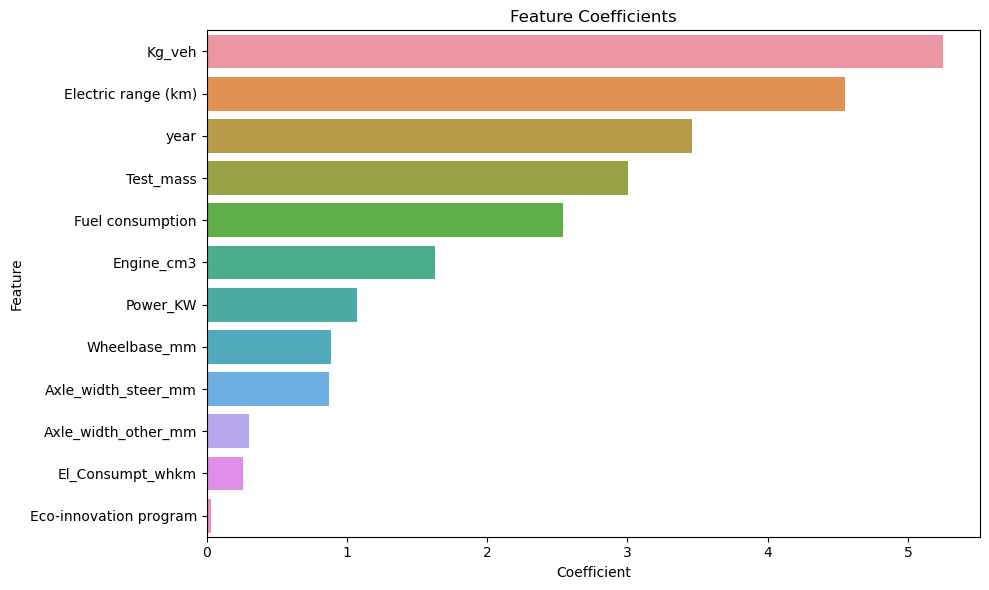

Energy Type: hybrid diesel
Best Alpha: 3.180625692794119e-10
Best R^2 Score: 0.9707541065964735
Mean Squared Error: 4.33497610106048


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


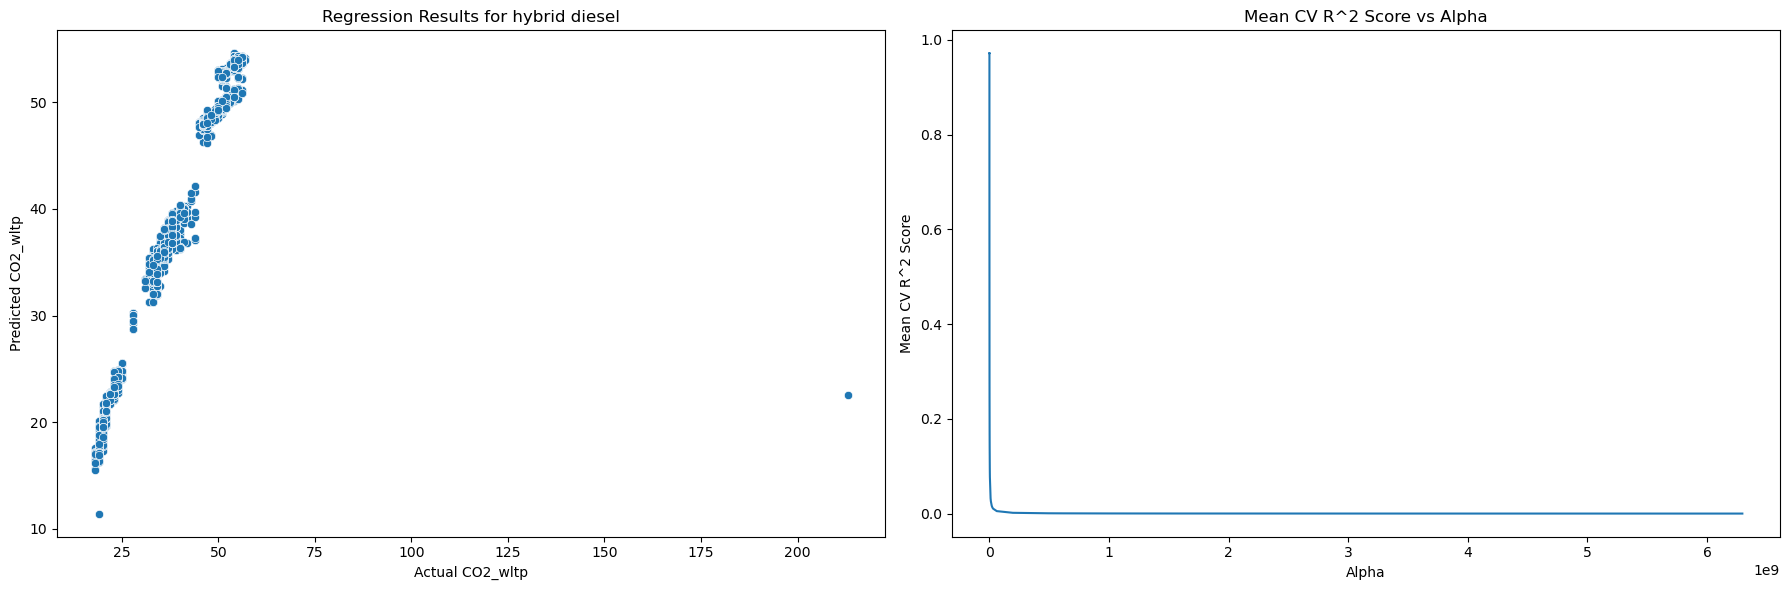

Feature Importances:
Electric range (km): 15.15836231506519
Axle_width_other_mm: 5.085555275835282
Axle_width_steer_mm: 4.700462799287307
Kg_veh: 3.5427844463638793
Wheelbase_mm: 1.0549778112566566
Test_mass: 0.8694784333814961
El_Consumpt_whkm: 0.7209748735173682
Fuel consumption: 0.17382964909446866
Power_KW: 0.15009164476860606
year: 0.04635240135501601
Eco-innovation program: 0.0
Erwltp (g/km): 0.0


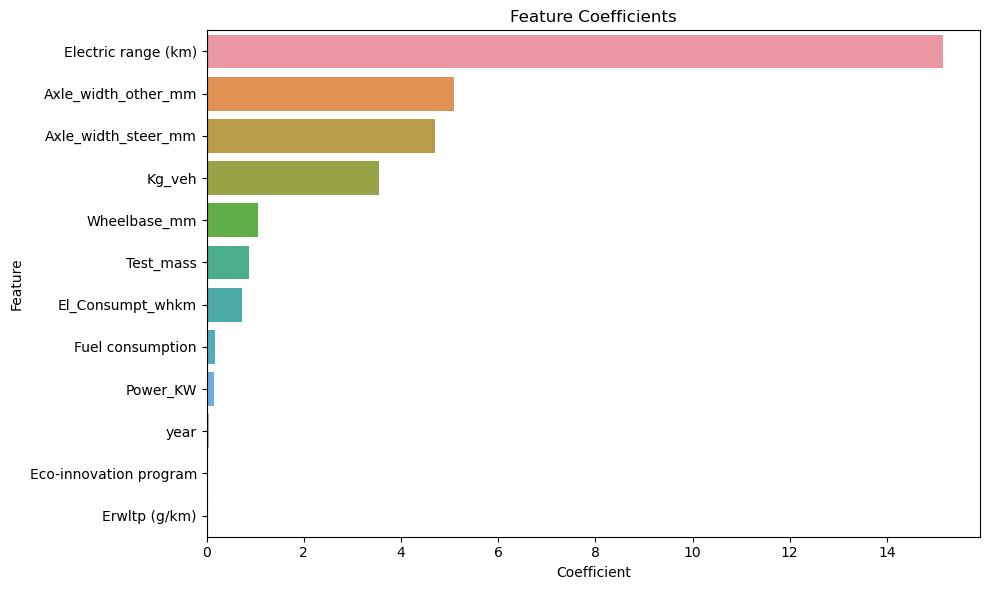

In [7]:
# Apply Ridge Regression for each energy type and all together with polynomial features
alphas = np.logspace(-10, 10, 200)
results = {}
for energy, features in features_dict.items():
    results[energy] = ridge_regression_with_random_search(df_clean, energy, features_dict, alphas, degree=1)

In [8]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = ridge_regression_with_random_search(df_clean, all_energies, features_dict, alphas, degree=1)

Process LokyProcess-22:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 456, in _process_worker
    mem_usage = _get_memory_usage(pid, force_gc=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 108, in _get_memory_usage
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 